In [242]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.debugger import set_trace
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15, 8)

In [6]:
DATA_FILE = "owid-covid-data.csv"
TRAIN_SIZE = 60

## .
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).


In [7]:
df = pd.read_csv(DATA_FILE, header=0,parse_dates=['date'])

In [8]:
ru_df = df[(df.location=='Russia') & (df.date>pd.datetime(2020,3,3))]

In [9]:
ru_df.loc[:,'day'] = ru_df.loc[:,'date'].apply(lambda x:x.dayofyear)
ru_df['day'] = ru_df['day']-ru_df['day'].iloc[0]

/home/vlad/miniconda3/envs/made/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/vlad/miniconda3/envs/made/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/vlad/miniconda3/envs/made/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [18]:
y_new = ru_df.new_cases
y_tot = ru_df.total_cases

In [589]:
X = day.values.reshape(-1,1)

In [13]:
X_tr, X_val = X[:TRAIN_SIZE], X[TRAIN_SIZE:]
y_new_tr, y_new_val = y_new[:TRAIN_SIZE], y_new[TRAIN_SIZE:]
y_tot_tr, y_tot_val = y_tot[:TRAIN_SIZE], y_tot[TRAIN_SIZE:]

## .
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально.

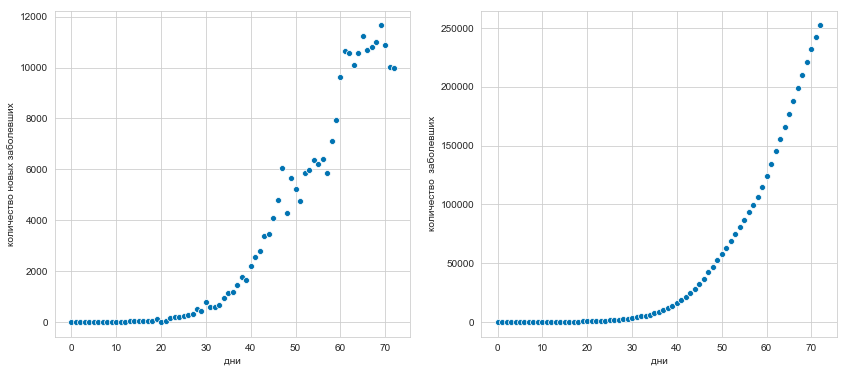

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

f_new = sns.scatterplot(x=day.values, y=y_new,ax=axes[0])
f_new.set(xlabel='дни',ylabel='количество новых заболевших')

f_tot = sns.scatterplot(x=day.values, y=y_tot,ax=axes[1])
f_tot.set(xlabel='дни',ylabel='количество  заболевших')

plt.show()

### .
Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.
Проведем логарифмирование целевой переменной и будем решать задачу вида: ln(y) ~ (линейная функция от x)

In [27]:
y_new_log = np.log(y_new,where=(y_new>1e-16))
y_tot_log = np.log(y_tot)

In [119]:
new_case_model = LinearRegression()
new_case_model.fit(X_tr,y_new_log[:TRAIN_SIZE])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [120]:
tot_case_model = LinearRegression()
tot_case_model.fit(X_tr,y_tot_log[:TRAIN_SIZE])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [121]:
y_new_pred_log = new_case_model.predict(X)
y_tot_pred_log = tot_case_model.predict(X)

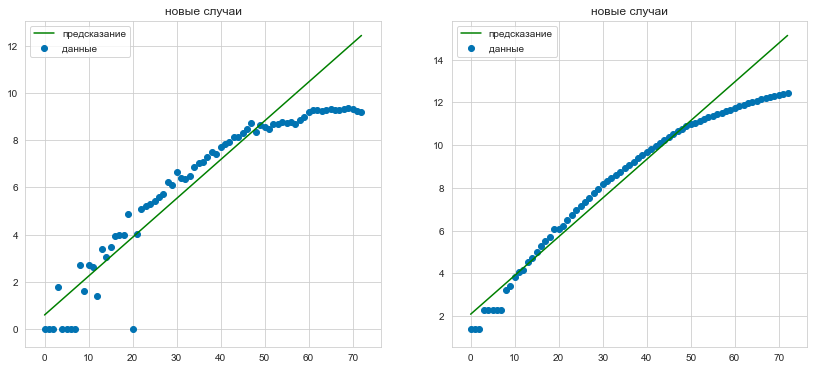

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax=axes[0]
ax.plot(X.reshape(-1), y_new_pred_log, color='g',label='предсказание')
ax.scatter(X.reshape(-1), y_new_log,label='данные')
ax.set_title('новые случаи')
ax.legend()

ax=axes[1]
ax.plot(X.reshape(-1), y_tot_pred_log, color='g', label='предсказание')
ax.scatter(X.reshape(-1), y_tot_log, label='данные')
ax.set_title('новые случаи')
ax.legend()


plt.show()

In [123]:
y_new_pred = np.exp(y_new_pred_log)
y_tot_pred = np.exp(y_tot_pred_log)

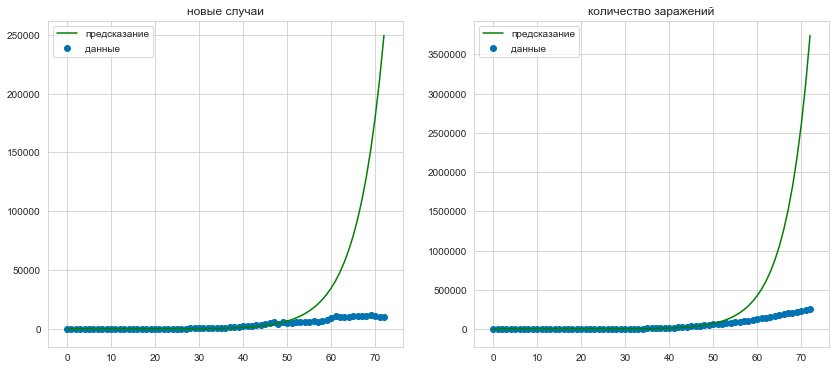

In [129]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax=axes[0]
ax.plot(X.reshape(-1),y_new_pred , color='g',label='предсказание')
ax.scatter(X.reshape(-1), y_new,label='данные')
ax.set_title('новые случаи')
ax.legend()

ax=axes[1]
ax.plot(X.reshape(-1), y_tot_pred, color='g', label='предсказание')
ax.scatter(X.reshape(-1), y_tot, label='данные')
ax.set_title('количество заражений')
ax.legend()


plt.show()

Прогноз весьма пессимистический, и не соответсвует реальности, за счет быстрого роста экспоненты.

### .
Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [246]:
def bayesian_update(sigma0, mu0, variance, x, y):
    X = np.ones((x.shape[0], x.shape[1]+1))
    X[:,1:] = x
    inv_sigma0 = np.linalg.inv(sigma0)
    
     
    sigma = inv_sigma0 + 1/variance*(X.T@X)
    sigma = np.linalg.inv(sigma)
    
    mu = inv_sigma0@mu0 + 1/variance*X.T@y
    mu = sigma@mu
    return sigma, mu

In [349]:
ru_df.tail(1)[['date','day']]

,date,day
14010,2020-05-15,72


In [399]:
june = pd.datetime(2020,6,1)
sep = pd.datetime(2020,9,1)

In [400]:
tot_days = (sep-pd.datetime(2020,5,15)).days
june_days = (june-pd.datetime(2020,5,15)).days

In [401]:
X_test = np.arange(73,73+tot_days).reshape(-1,1)
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test))

In [402]:
sigma_tot = np.identity(2)
mu_tot = np.zeros(2)
tot_case_model.fit(X,y_tot_log)
variance = (tot_case_model.predict(X)-y_tot_log.values).var()

sigma_tot, mu_tot = bayesian_update(sigma_tot, mu_tot, variance,
                            X, y_new_log.values)

In [414]:
print(f"параметры модели sigma=\n{sigma_tot}\n mu={mu_tot}")

параметры модели sigma=
[[ 2.88950787e-02 -5.97826607e-04]
 [-5.97826607e-04  1.67323815e-05]]
 mu=[1.15242825 0.13791103]


In [403]:
n_samples = 300
Wsamp = np.random.multivariate_normal(mu_tot, sigma_tot, n_samples)

In [418]:
X_val_bias = np.hstack((np.ones((X.shape[0],1)),X))

In [419]:
y_pred_val = np.array([np.exp(X_val_bias@W) for W in Wsamp])

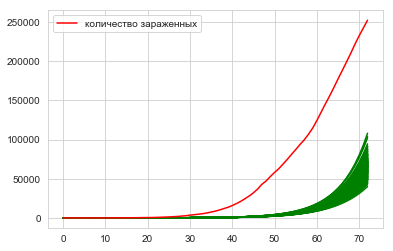

In [427]:
days = X.reshape(-1)
for y_samp in y_pred_val:
    plt.plot(days, y_samp, color='g')
plt.plot(days, y_tot, color='red', label='количество зараженных')

plt.legend()
plt.show()

In [404]:
y_res_tot = np.array([np.exp(X_test@W) for W in Wsamp])

In [439]:
y_res_tot_mean = np.mean(y_res_tot, axis=0)

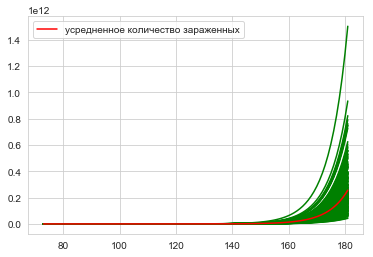

In [441]:
days = np.arange(73,73+tot_days)

for y_samp in y_res_tot:
    plt.plot(days, y_samp, color='g')

plt.plot(days, y_res_tot_mean, color='red', label='усредненное количество зараженных')
plt.legend()
plt.show()

In [442]:
print(f"""Количество заболевших к 1 июня: {y_res_tot_mean[june_days-1]:.2E}
Количество заболевших к 1 сентября: {y_res_tot_mean[tot_days-1]:.2E}""")

Количество заболевших к 1 июня: 6.92E+05
Количество заболевших к 1 сентября: 2.56E+11


In [449]:
n_samples = 8000
Wsamp = np.random.multivariate_normal(mu_tot, sigma_tot, n_samples)

In [450]:
y_res_tot = np.array([np.exp(X_test@W) for W in Wsamp])

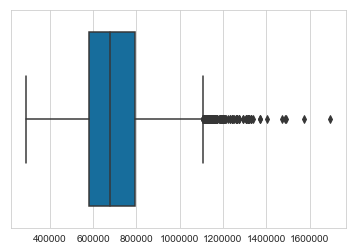

перцентили количества зараженных 1 июня:
percentile 25=5.81E+05
percentile 50=6.76E+05
percentile 75=7.91E+05


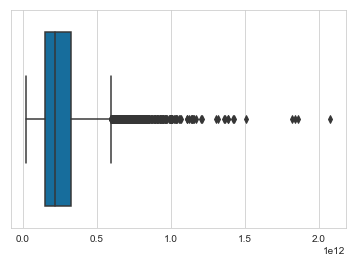

перцентили количества зараженных 1 сентября:
percentile 25=1.48E+11
percentile 50=2.19E+11
percentile 75=3.26E+11


In [511]:
sns.boxplot(y_res_tot[:,june_days-1])
plt.show()

perc=np.percentile(y_res_tot[:,june_days-1],[25,50,75])

print("перцентили количества зараженных 1 июня:")
for p,v in zip([25,50,75],perc):
    print(f"percentile {p}={v:0.2E}")

sns.boxplot(y_res_tot[:,tot_days-1])
plt.show()

perc=np.percentile(y_res_tot[:,tot_days-1],[25,50,75])

print("перцентили количества зараженных 1 сентября:")
for p,v in zip([25,50,75],perc):
    print(f"percentile {p}={v:0.2E}")

In [509]:
jun_tot = y_res_tot[:,june_days-1]
jun_tot = jun_tot[jun_tot<11e5]
sep_tot = y_res_tot[:,tot_days-1]
sep_tot = sep_tot[sep_tot<6e11] 

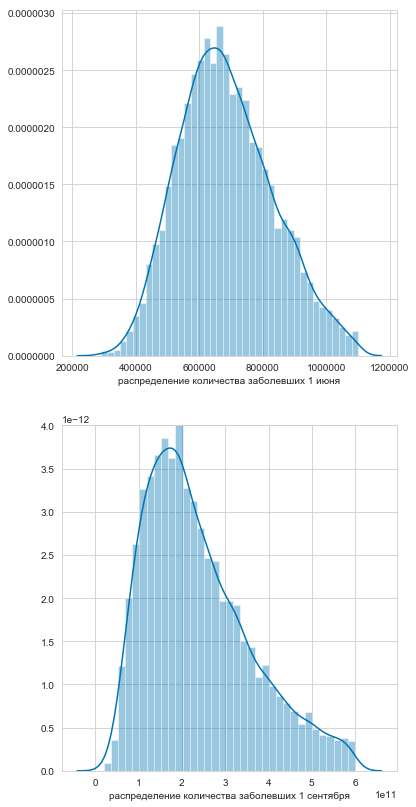

In [510]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,14))

f_new = sns.distplot(jun_tot,ax=axes[0])
f_new.set(xlabel='распределение количества заболевших 1 июня')

f_tot = sns.distplot(sep_tot,ax=axes[1])
f_tot.set(xlabel='распределение количества заболевших 1 сентября')

plt.show()

Предсказание для 1 июня симметрично, и более-менее реально, для скорости распространения в июне.
Предсказание для 1 сентября скошено, и не согласуется со здравым смыслом.

## . 
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение

### .

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

В предложенной модели

$ total\_cases(x)=\int_{-\infty}^{x}e^{at^2+bt+c} dt \approxeq \sum e^{at_i^2+bt_i+c}\Delta_i=\sum new\_cases(x)$. (привет интеграл Римана)

т.о. можно считать с определенной огрешностью количество новых случаев равным $e^{at^2+bt+c}$.

In [544]:
X_2_tr = PolynomialFeatures(2, include_bias=False).fit_transform(X_tr)
X_2_val = PolynomialFeatures(2, include_bias=False).fit_transform(X_val)

In [545]:
sig_model = LinearRegression()

In [546]:
sig_model.fit(X_2_tr,y_new_log[:TRAIN_SIZE])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [547]:
sig_model.coef_

array([ 0.29068171, -0.00214268])

Коээфициент при $x^2$ отрицательный - похоже на правду.

In [549]:
sigma_new = np.identity(3)
mu_new = np.zeros(3)
variance = (sig_model.predict(X_2_tr)-y_new_log[:TRAIN_SIZE].values).var()
sigma_new, mu_new = bayesian_update(sigma_new, mu_new, variance,
                            X_2_tr, y_new_log[:TRAIN_SIZE].values)

In [556]:
n_samples = 300
Wsamp = np.random.multivariate_normal(mu_new, sigma_new, n_samples)
X_val_bias = np.hstack((np.ones((X_2_val.shape[0],1)),X_2_val))
y_pred_val = np.array([np.exp(X_val_bias@W) for W in Wsamp])

In [562]:
y_pred_val_mean = np.mean(y_pred_val, axis=0)

In [571]:
y_pred_tot_samp = np.cumsum(y_pred_val,axis=1)

In [572]:
y_pred_tot = np.cumsum(y_pred_val_mean)

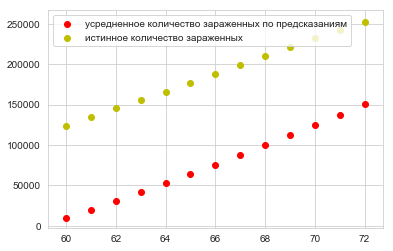

In [586]:
days = np.arange(TRAIN_SIZE,73)

plt.scatter(days, y_pred_tot, color='red', label='усредненное количество зараженных')
plt.scatter(days, y_tot_val, color='y', label='истинное количество зараженных')
plt.legend()
plt.show()

In [590]:
X_2 = PolynomialFeatures(2, include_bias=False).fit_transform(X)

In [591]:
sig_model = LinearRegression()
sig_model.fit(X_2,y_new_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [592]:
sigma_new = np.identity(3)
mu_new = np.zeros(3)
variance = (sig_model.predict(X_2)-y_new_log.values).var()
sigma_new, mu_new = bayesian_update(sigma_new, mu_new, variance,
                            X_2, y_new_log.values)

In [599]:
june = pd.datetime(2020,6,1)
sep = pd.datetime(2020,9,1)

tot_days = (sep-pd.datetime(2020,5,15)).days
june_days = (june-pd.datetime(2020,5,15)).days

X_test = np.arange(73,73+tot_days).reshape(-1,1)

In [600]:
X_test_2 = PolynomialFeatures(2, include_bias=False).fit_transform(X_test)

In [638]:
n_samples = 100
Wsamp = np.random.multivariate_normal(mu_new, sigma_new, n_samples)
X_test_bias = np.hstack((np.ones((X_test_2.shape[0],1)),X_test_2))
y_pred = np.array([np.exp(X_test_bias@W) for W in Wsamp])

In [639]:
y_pred_tot_samp = np.cumsum(y_pred,axis=1)

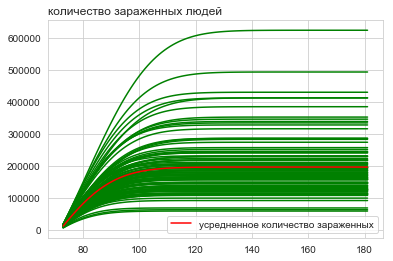

In [645]:
days = np.arange(73,73+tot_days)

for y_samp in y_pred_tot_samp:
    plt.plot(days, y_samp, color='g')

plt.plot(days, np.mean(y_pred_tot_samp,axis=0), color='red', label='усредненное количество зараженных')
plt.title("количество зараженных людей",loc='left')
plt.legend()
plt.show()

In [628]:
n_samples = 10000
Wsamp = np.random.multivariate_normal(mu_new, sigma_new, n_samples)
X_test_bias = np.hstack((np.ones((X_test_2.shape[0],1)),X_test_2))
y_pred = np.array([np.exp(X_test_bias@W) for W in Wsamp])

y_pred_tot_samp = np.cumsum(y_pred,axis=1)

In [629]:
y_pred_tot_samp.shape

(10000, 109)

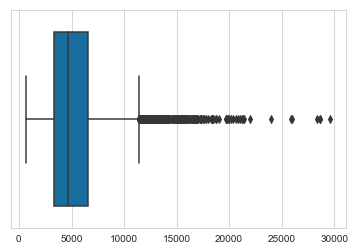

перцентили количества новых заражений 1 июня:
percentile 10=2.45E+03
percentile 25=3.30E+03
percentile 50=4.63E+03
percentile 75=6.54E+03
percentile 90=8.90E+03


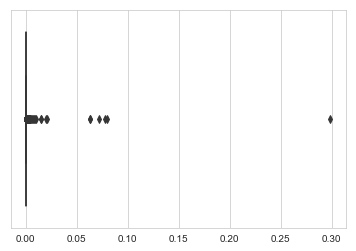

перцентили количества новых заражений 1 сентября:
percentile 10=2.51E-10
percentile 25=2.60E-09
percentile 50=3.94E-08
percentile 75=6.44E-07
percentile 90=6.87E-06


In [636]:
june_val_new = y_pred[:,june_days-1]
sept_val_new = y_pred[:,tot_days-1]

sns.boxplot(june_val_new)
plt.show()

perc=np.percentile(june_val_new,[10,25,50,75,90])

print("перцентили количества новых заражений 1 июня:")
for p,v in zip([10,25,50,75,90],perc):
    print(f"percentile {p}={v:0.2E}")

sns.boxplot(sept_val_new)
plt.show()

perc=np.percentile(sept_val_new,[10,25,50,75,90])

print("перцентили количества новых заражений 1 сентября:")
for p,v in zip([10,25,50,75,90],perc):
    print(f"percentile {p}={v:0.2E}")

In [630]:
june_val = y_pred_tot_samp[:,june_days-1]
sept_val = y_pred_tot_samp[:,tot_days-1]

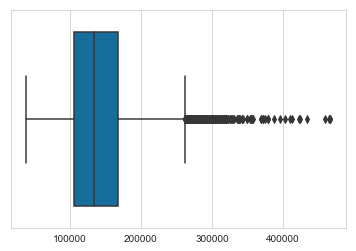

перцентили количества зараженных 1 июня:
percentile 10=8.68E+04
percentile 25=1.06E+05
percentile 50=1.33E+05
percentile 75=1.68E+05
percentile 90=2.08E+05


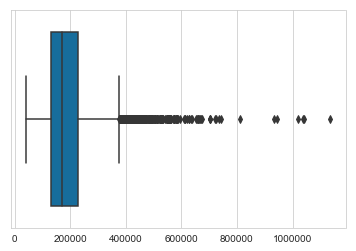

перцентили количества зараженных 1 сентября:
percentile 10=1.03E+05
percentile 25=1.30E+05
percentile 50=1.72E+05
percentile 75=2.29E+05
percentile 90=3.01E+05


In [633]:
sns.boxplot(june_val)
plt.show()

perc=np.percentile(june_val,[10,25,50,75,90])

print("перцентили количества зараженных 1 июня:")
for p,v in zip([10,25,50,75,90],perc):
    print(f"percentile {p}={v:0.2E}")

sns.boxplot(sept_val)
plt.show()

perc=np.percentile(sept_val,[10,25,50,75,90])

print("перцентили количества зараженных 1 сентября:")
for p,v in zip([10,25,50,75,90],perc):
    print(f"percentile {p}={v:0.2E}")

Прогноз выглядит достаточно хорошим, к 1 июня количество новых заражений будет не больше 8 тысяч в день.

Построим значения усредненного количества новых заражений.

In [655]:
mean_new = np.mean(y_pred, axis=0)

[Text(0, 0.5, 'количество новых заболевших'), Text(0.5, 0, 'дни')]

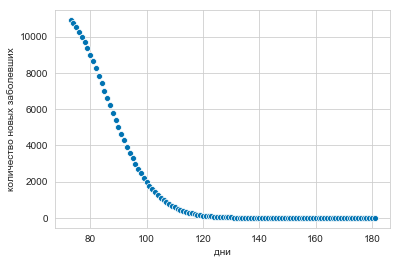

In [656]:
f_new = sns.scatterplot(x=days, y=mean_new)
f_new.set(xlabel='дни',ylabel='количество новых заболевших')

Построим графики распределения зараженных на 1 июня и 1 сентября

In [661]:
jun_tot = y_pred_tot_samp[:,june_days-1]
jun_tot = jun_tot[jun_tot<2.08E+05]
sep_tot = y_pred_tot_samp[:,tot_days-1]
sep_tot = sep_tot[sep_tot<3.01E+05] 

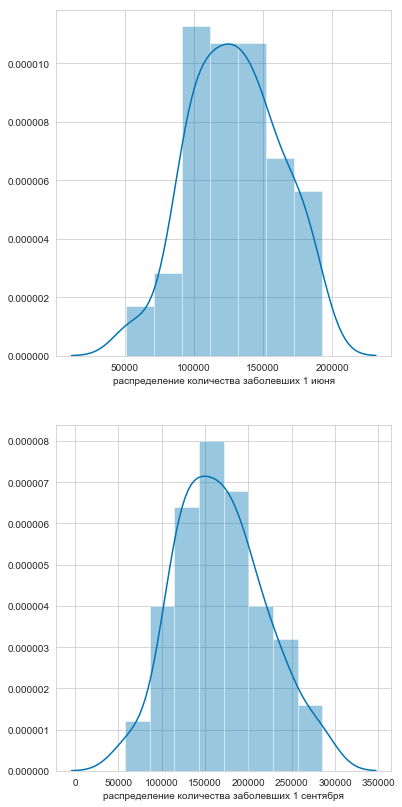

In [662]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,14))

f_new = sns.distplot(jun_tot,ax=axes[0])
f_new.set(xlabel='распределение количества заболевших 1 июня')

f_tot = sns.distplot(sep_tot,ax=axes[1])
f_tot.set(xlabel='распределение количества заболевших 1 сентября')

plt.show()